# Module 6: Descriptive and Predictive Modeling
## Exercise 2: A complete, non-guided Data Mining pipeline


### Work performed by:
#### Rafael Haba Díaz 79030459K
#### Hugo Puerto Rosello 76884689J

In [1]:
#Importing Libraries
import pandas as pd
from sklearn.datasets import load_digits
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from time import time
from sklearn.svm import SVC
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN 
from imblearn.combine import SMOTETomek 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [7]:
!pip install --user imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)


## General Description of the Dataset
This is a dataset that contains for every row a wine, where every column is a property of it. This columns are:  fixed acidity,  volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH,  sulphates, alcohol, quality. In this case, features are going to be every column except quality and obviously the category is going to be the quality. 

For this task, we are going to make classifications, with some models, showing their performance with different scores and a confusion matrix, also, we are going to make some explanations due to the results that every model gives. 

### Read the dataset, create a DataFrame and show the variables type:

In [3]:
df = pd.read_csv('winequality-red.csv', sep =';')
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

In [4]:
df.shape

(1599, 12)

### Alcohol column is type object (string). This is because it has some rows wich values have more than one ".". Let's correct this issue: 
1. Go over all raws and count how many "." has the column alcohol.
2. When the value has more than one ".", drop the row.
3. Print the value, making sure it was a wrong one.

In [5]:
i = 0
while i < len(df):
    cadena = df.loc[i,['alcohol']].values
    ocurrencias = str(cadena).count('.')
    if(ocurrencias != 0 and ocurrencias != 1):
        print(cadena)
        df = df.drop(i)
    i = i +1

['100.333.333.333.333']
['100.333.333.333.333']
['110.666.666.666.667']
['956.666.666.666.667']
['135.666.666.666.667']
['923.333.333.333.333']


### Change the type of the column "alcohol" to float:

In [6]:
df = df.astype('float')
df.shape

(1593, 12)

### Make sure alcohol column has changed to float:

In [7]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
dtype: object

### Show how many different quality metrics are for wines:
As we see, there are six different categories: [5, 6, 7, 4, 8, 3]

In [8]:
df['quality'].unique().tolist()

[5.0, 6.0, 7.0, 4.0, 8.0, 3.0]

### Generate the X and y, where X contains the features and y the categories:

In [9]:
X = df.iloc[:,:-1].values

In [10]:
y = df.iloc[:,11].values

### Let's plot a boxplot to see if we have to normalize the dataframe:
As we see in the next boxplot, features from different columns are moving through really far values, so, we must normalize.

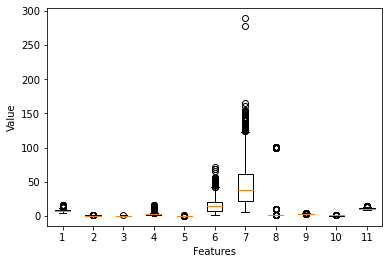

In [11]:
plt.boxplot(X)
plt.xlabel("Features")
plt.ylabel("Value")
plt.show()

### Let's see how features see in a boxplot after normalizing:
As we see in the boxplot after normalizing, we could think about classifying those points as outliers, but we are not going to manage them, because we think that they could be part of those categories that have less samples.

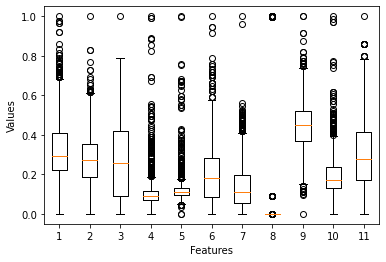

In [12]:
scaler = MinMaxScaler()
X_scal = scaler.fit_transform(X)
plt.boxplot(X_scal)
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### Number of appearances of every category: 
As wee see, classes are really unbalanced, so we must balanced them using over-sampling. Training the dataset with unbalanced categories should give us really bad results for these categories that are not balanced. We are going to make comparisons between the results with an unbalanced and balanced categories.

In [23]:
Apariciones = df.quality.value_counts()

In [24]:
Apariciones

5.0    681
6.0    633
7.0    198
4.0     53
8.0     18
3.0     10
Name: quality, dtype: int64

### Balancing classes with imblearn. 
In this case, we are using the SMOTETomek method, which combines SMOTE(Synthetic Minority Oversampling Technique) and Tomek links. Tomek links are pairs of very close instances,but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

Tomek links remove unwanted overlap between classes where majority class links are removed until all minimally distanced nearest neighbor pairs are of the same class.

So, we have simultanously an oversampling (SMOTE) and subsampling (Tomek links) method. Having balanced classes, should increase the scores of our models, we are going to prove this by comparing the performance of our models with balanced classes and without balanced classes.

In [25]:
def SMOTE_TOMEK_BAL(X, y):
    emb = SMOTETomek(random_state = 13)
    X_bal, y_bal = emb.fit_resample(X, y)
    ocurrencias_y_balanced = collections.Counter(y_bal.tolist())
    ocurrencias_y = collections.Counter(y.tolist())

    return X_bal, y_bal

In [26]:
X_bal, y_bal = SMOTE_TOMEK_BAL(X, y)
scaler = MinMaxScaler()
X_bal = scaler.fit_transform(X_bal)

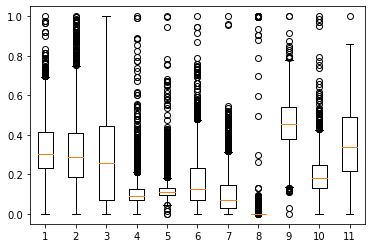

In [27]:
plt.boxplot(X_bal)
plt.show()

### Let's see how many clusters does the KMeans Model give, using the elbow method:
Now that we have our categories balanced, it could be interesting seeing on how many clusters does the KMeans model divide our data. For this, we have used the elbow method and the result is very far from what we expected, it divides data in only 2 clusters, when we have 6 categories, it has seriously problems to distinguish the categories that we have. 

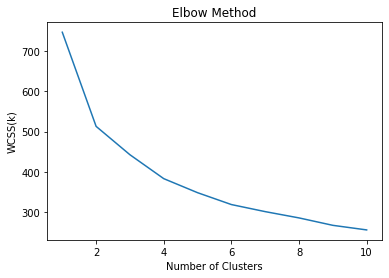

In [28]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10)
    kmeans.fit(X_bal)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title("Elbow Method")
plt.ylabel("WCSS(k)")
plt.xlabel("Number of Clusters")
plt.show()    

## Reduce the dimension of the variables and plot them
In this section, we are going to show the distribution of the samples when we reduce the model to a 2D one. For this, we must reduce the dimension of our features. We have two choices, we can reduce the dimension by a linear reduction using the method PCA from sklearn or we can see the correlation between the features and y and then plot the two ones that have more correlation with it. 

### Reducing dimension: PCA
If we use PCA for reducing the dimension, we can see in the next plot that it is impossible to distinguish the clusters we have in 2D. We lose a lot of information with the linear combination.

In [29]:
miPCA = PCA(n_components=2)
Xtr = miPCA.fit_transform(X_bal)

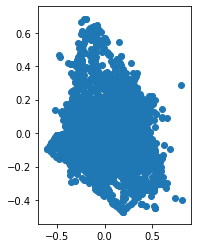

In [30]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(Xtr[:,0],Xtr[:,1])

In [31]:
print("Varianza PCA: "+ str(Xtr.var(axis=0)))
print("Varianza Xbal: " + str(X_bal.var(axis=0)))

Varianza PCA: [0.07977502 0.03808929]
Varianza Xbal: [0.02042521 0.02873291 0.04098393 0.0075552  0.00530445 0.0183114
 0.0097264  0.00555109 0.01431481 0.00837655 0.0332627 ]


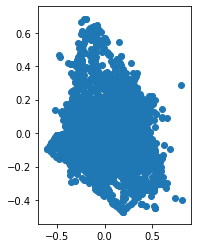

In [32]:
miPCA = PCA(n_components=2)
Xtr = miPCA.fit_transform(X_bal)
plt.figure()
plt.subplot(1,2,1)
plt.scatter(Xtr[:,0],Xtr[:,1])

### Reducing dimension: Correlation
We are going to plot a representation of the correlation between the features and the category column. We think it could be very interesting to see wich features are the most important to define the final result of the categories. In this case, as we see, this features corresponds to the columns 10, 9 and 2. 

In [33]:
df_bal = pd.DataFrame(X_bal)
df_bal['quality'] = y_bal

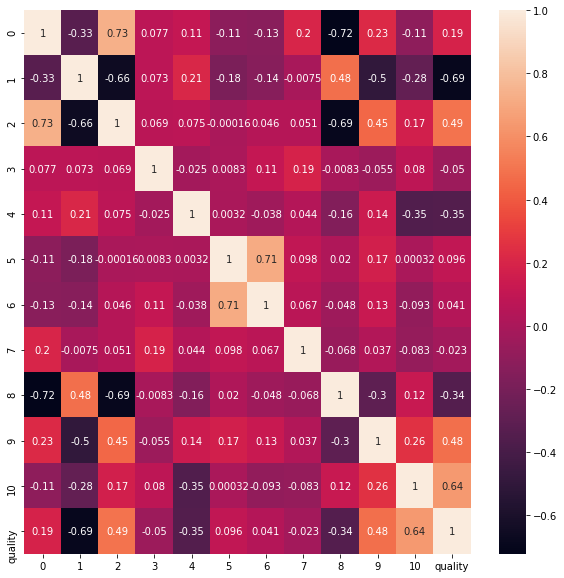

In [34]:
correlation_mat = df_bal.corr()
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(correlation_mat, annot = True, ax = ax)
plt.show()

##  Useful Functions For The Different Models:
We are going to define some functions that are going to be used in the different models. This should make our code easier to read and also with less repetition of same lines. 

### Plot Confusion Matrix

In [35]:
def plt_confusion_matrix(clfBest, X_test, y_test):
    #plot confusion matrix
    fig,ax = plt.subplots(figsize = (10,10))
    disp = plot_confusion_matrix(clfBest, X_test, y_test, ax = ax)
    
    #plot confusion matrix
    plt.show()

### Scores

In [36]:
def scores(y_test, y_train, y_pred, clfBest):
    accuracyStratifiedCV = accuracy_score(y_test, y_pred)
    f1ScoreStratifiedCV = f1_score(y_test, y_pred,average = 'macro')
    recallStratifiedCV = recall_score(y_test, y_pred,average = 'macro')
    precisionStratifiedCV = precision_score(y_test, y_pred,average = 'macro')     
    ocurrenciasStratifiedCV = collections.Counter(y_train)
    
    print("------------------------")
    print("Best Classifier: "+str(clfBest))
    print("Accuracy StratifiedCV: "+ str(accuracyStratifiedCV))   
    print("f1Score StratifiedCV: "+ str(f1ScoreStratifiedCV))
    print("recall StratifiedCV: "+ str(recallStratifiedCV))
    print("precision StratifiedCV: "+ str(precisionStratifiedCV))
    print("Ocurrencias StratifiedCV: " + str(ocurrenciasStratifiedCV))
    print("------------------------")

### Stratification

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
def stratification(X,y, n_splits,test_size, random_state):
    sss = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state) 
    for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

### Model Function

In [38]:
def Model(X,y, pipeline, params, test_size, n_splits, random_state, cv):
    X_train, X_test, y_train, y_test = stratification(X,y, n_splits,test_size, random_state)
           
    gs = GridSearchCV(estimator=pipeline,param_grid=params,scoring='accuracy',cv=cv, verbose=2)
    
    gs.fit(X_train,y_train)
    resultsCV = gs.cv_results_
    
    clfBest = gs.best_estimator_
    clfBest.fit(X_train,y_train)
    
    y_pred = clfBest.predict(X_test)
    
    #plot confusion matrix
    plt_confusion_matrix(clfBest, X_test, y_test)
    
    scores(y_test, y_train, y_pred, clfBest)

## 1. KNN
We are going to use a KNN with a stratified crossvalidation we are going to set as inputs for the crossvalidation the number of neighbors ([3,5,7,9,11,13,15,17]), weights([uniform, distance]), p([1,2]) and cv.

We are going to execute the algorithm 3 times, a first one using an unbalanced X, y a second execution using balanced X, y and a thir exection with a dimension reduced X.

The results we have are good for the algorithm executed with the KNN with balanced cateogories but not very good with the unbalanced one. If we see the confusion matrix of the unbalanced execution, we can see that it hardly ever finds the correct category of these categories that are unbalanced.

On the other hand, if we analyze the confusion matrix of the KNN model with the balanced X, y, we see that it does really well with the categories that were not balanced, this could be because te samples added to the unbalanced classes are similar and the Tomek links remove unwanted overlap between classes, so the algorithm can distinguish better the categories.

If we use KNN and a dimension reduced X with columns 10, 9 and 2, we have really good results, they are really near from the model that uses all the features. In some cases, it could be a really good option, reducing the dimensions from 11 to 3 reduces also the computation efforts and the results are not very far from each other (a little bit worse).

### 1.1 Setting the common parameters in KNN:

In [39]:
n_splits = 1
test_size = 0.3
cv = 5
p = [1,2]
random_state = 13
n_neighbors = [3,5,7,9,11,13,15,17]
weights = ['uniform', 'distance']

### 1.2 Setting the pipeline for KNN:


In [40]:
estimators1 = [('scale', MinMaxScaler()), ('knn', KNeighborsClassifier())]
params = {'knn__n_neighbors':n_neighbors,'knn__weights':weights, 'knn__p':p}
p1 = Pipeline(estimators1)

### 1.3 KNN Unbalanced Categories (Scaler--->KNN)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__we

[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbo

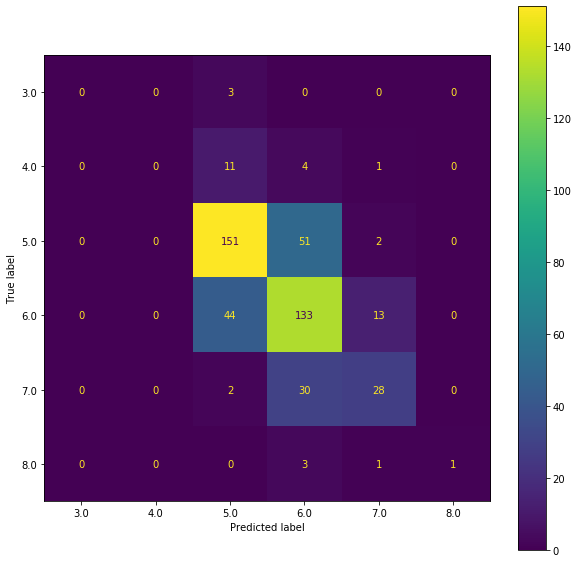

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=17, weights='distance'))])
Accuracy StratifiedCV: 0.6548117154811716
f1Score StratifiedCV: 0.3735965760853634
recall StratifiedCV: 0.35114379084967323
precision StratifiedCV: 0.4899453312333156
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
Model(X,y, p1, params, test_size, n_splits, random_state, cv)

### 1.4 KNN Balanced Categories (Scaler--->KNN)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__we

[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbo

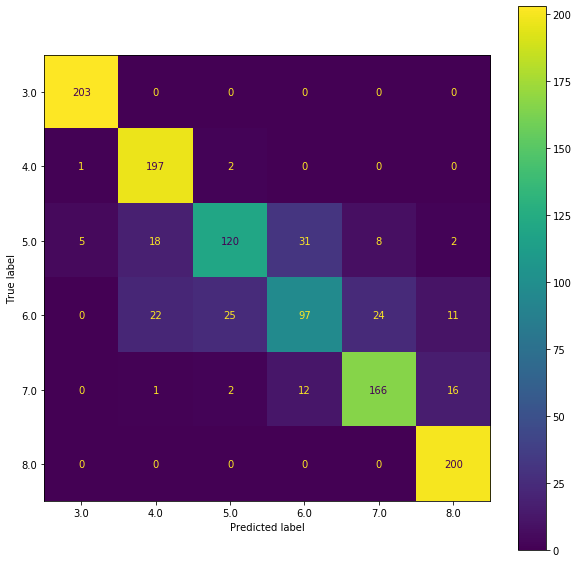

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])
Accuracy StratifiedCV: 0.8452278589853827
f1Score StratifiedCV: 0.831126454109055
recall StratifiedCV: 0.836952158048815
precision StratifiedCV: 0.834832585439715
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [42]:
Model(X_bal,y_bal, p1, params, test_size, n_splits, random_state, cv)

### 1.5 KNN  Dimensions reduced using Correlation (Scaler--->KNN)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__we

[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=1, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbors=13, knn__p=2, knn__weights=uniform; total time=   0.0s
[CV] END knn__n_neighbo

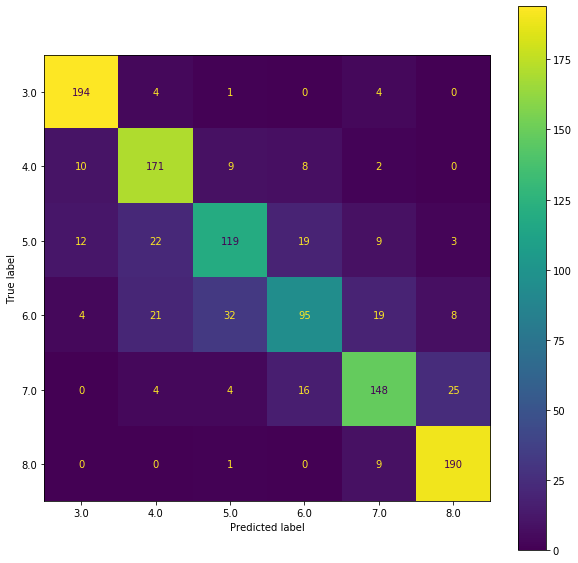

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])
Accuracy StratifiedCV: 0.7884780739466896
f1Score StratifiedCV: 0.7769931143256432
recall StratifiedCV: 0.7815665745969267
precision StratifiedCV: 0.7788231322698055
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [43]:
Model(X_bal[:, [0,2,9,10]],y_bal, p1, params, test_size, n_splits, random_state, cv)

## 2. SVC
The second model we are going to use is the support vector classifier. As we did with te KNN algorithm, we are going to make a comparison between doing with an unbalanced and balanced X, y. In this case, the parameters we are going to use in the cv are:
C:[0.1,1,10,100], kernel:['rbf','sigmoid'], degree:[2,3], gamma:['scale', 'auto', 0.1], coef0:[0.0]. 

As it did in KNN, the SVC model, classifies the minority classes with balanced X,y really well. Balancing X, y, supposes an increase in the scores. The scores are a little bit worse than in KNN model.

As we did in KNN, we are going to make a comparisson between dimension reduced and non dimension reduced (balanced). In this case, and using the same X features as we used in KNN (X[:, 9,10,2]), the results are much worse than using all features. SVC model has not tolerate the dimension as well as the KNN model.

### 2.1 Setting the common parameters in SVC:

In [44]:
estimators2 = [('scale', MinMaxScaler()), ('svc', SVC())]
params = {'svc__C':[0.1,1,10,100],
          'svc__kernel':['rbf','sigmoid'],
          'svc__degree':[2,3],
          'svc__gamma':['scale', 'auto', 0.1],
          'svc__coef0':[0.0]}

### 2.2 Setting the pipeline for SVC:

In [45]:
p2 = Pipeline(estimators2)

### 2.3 SVC Pipeline Unbalanced (Scaler--->SVC)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__ker

[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.

[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=10, svc__coef0=0.0, svc

[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s


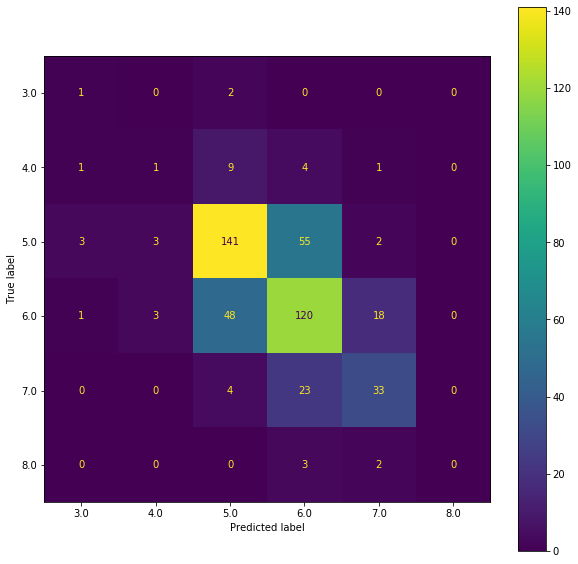

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()), ('svc', SVC(C=100, degree=2))])
Accuracy StratifiedCV: 0.6192468619246861
f1Score StratifiedCV: 0.36281927808330466
recall StratifiedCV: 0.37809812521499825
precision StratifiedCV: 0.362558641342716
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
Model(X,y, p2, params, test_size, n_splits, random_state, cv)

### 2.4 SVC Balanced (Scaler--->SVC)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.7s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.9s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   1.1s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.9s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__ker

[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.4s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.4s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.4s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.

[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.6s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc

[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s


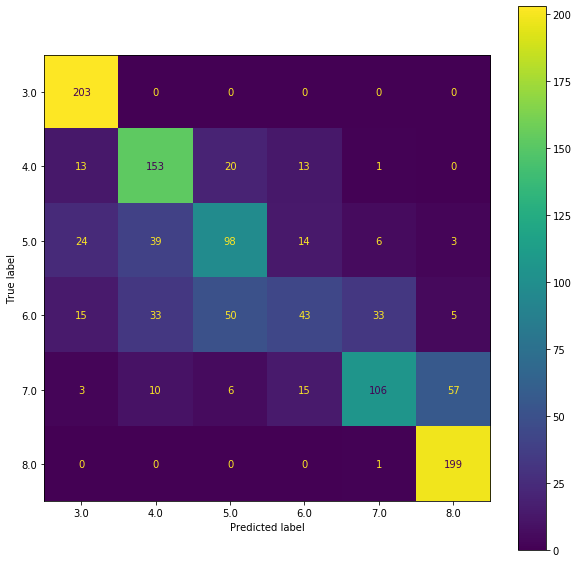

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()), ('svc', SVC(C=100, degree=2))])
Accuracy StratifiedCV: 0.6895958727429062
f1Score StratifiedCV: 0.6552372864605538
recall StratifiedCV: 0.6784838708881954
precision StratifiedCV: 0.6636437655202322
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [47]:
Model(X_bal[:, [0,9,10,2]],y_bal, p2, params, test_size, n_splits, random_state, cv)

### 2.5 SVC Using Reduction of Dimensions (Correlation):


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.9s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   1.1s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__kernel=sigmoid; total time=   1.2s
[CV] END svc__C=0.1, svc__coef0=0.0, svc__degree=2, svc__gamma=scale, svc__ker

[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=auto, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=1, svc__coef0=0.0, svc__degree=2, svc__gamma=0.

[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.5s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=scale, svc__kernel=sigmoid; total time=   0.6s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.9s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.6s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc__degree=3, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=10, svc__coef0=0.0, svc

[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s
[CV] END svc__C=100, svc__coef0=0.0, svc__degree=3, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.3s


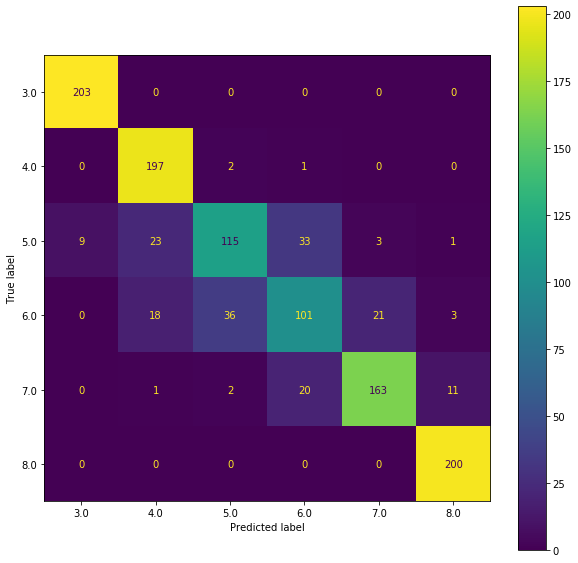

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()), ('svc', SVC(C=100, degree=2))])
Accuracy StratifiedCV: 0.8417884780739467
f1Score StratifiedCV: 0.8286463015215251
recall StratifiedCV: 0.8336094962614261
precision StratifiedCV: 0.8295422752475172
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [48]:
Model(X_bal,y_bal, p2, params, test_size, n_splits, random_state, cv)

## 3. Decission Tree
The decission tree may not give us really good results, but it is really quick and it does not need many computer requeriments. The parameters that we are giving to the model are: criterion:["gini", "entropy"], max_depth:[3,5,7,9,11], min_samples_split:[2,4,8,16].

As we see in the confusion matrix, it does really well with categories that were not balanced and really bad with the others, maybe it has been adjusted really well to these samples and gives that results. Despite of this, the scores were generally better in the balanced model.

In this case, the reduction of dimensions makes the model having much better results. The results it gives when reducing the dimensions are such good that we think we can use this model when we want to have results quickly and with an acceptable accuracy (0.73)

### 3.1 Setting the common parameters for the Decission Tree:

In [49]:
estimators3 = [('scale', MinMaxScaler()), ('tree', DecisionTreeClassifier())]
params = {'tree__criterion':["gini", "entropy"],
          'tree__max_depth':[3,5,7,9,11],
          'tree__min_samples_split':[2,4,8,16]}

### 3.2 Setting the Pipeline for the Decission Tree:

In [50]:
p3 = Pipeline(estimators3)

### 3.1 Unbalanced Decission Tree


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=

[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=g

[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=11, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=11, tree__min_samples_split=2; total time=   0.0s
[CV

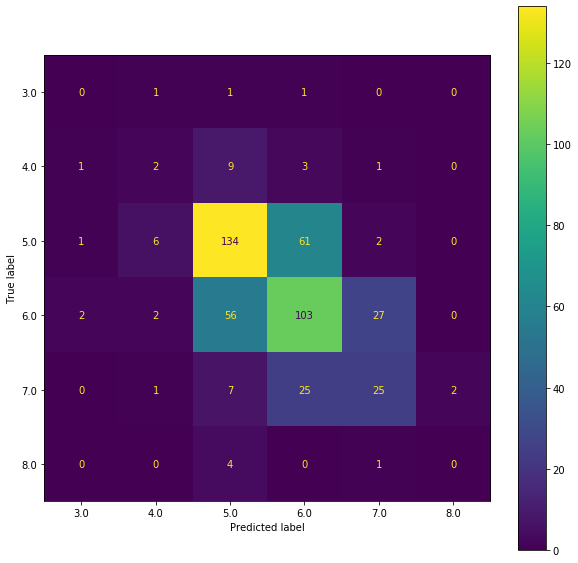

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('tree',
                 DecisionTreeClassifier(max_depth=9, min_samples_split=4))])
Accuracy StratifiedCV: 0.5523012552301255
f1Score StratifiedCV: 0.29292229432979705
recall StratifiedCV: 0.2901057791537668
precision StratifiedCV: 0.2969741807698859
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


In [51]:
Model(X,y, p3, params, test_size, n_splits, random_state, cv)

### 3.2 Balanced Decission Tree


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=

[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=gin

[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=11, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=11, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=11, tree__min_samples_split=2; total time=   0.0s
[C

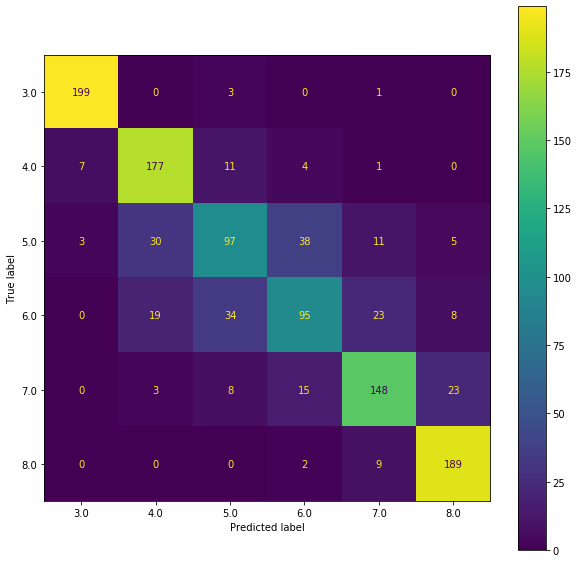

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('tree', DecisionTreeClassifier(max_depth=11))])
Accuracy StratifiedCV: 0.7781599312123818
f1Score StratifiedCV: 0.7643030987812859
recall StratifiedCV: 0.7699107953436961
precision StratifiedCV: 0.7637980495776701
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [52]:
Model(X_bal,y_bal, p3, params, test_size, n_splits, random_state, cv)

### 3.3 Decission Tree Using Reduction of Dimensions (Correlation):

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=2; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=3, tree__min_samples_split=

[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=4; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini, tree__max_depth=11, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=gini,

[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=8; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] END tree__criterion=entropy, tree__max_depth=9, tree__min_samples_split=16; total time=   0.0s
[CV] 

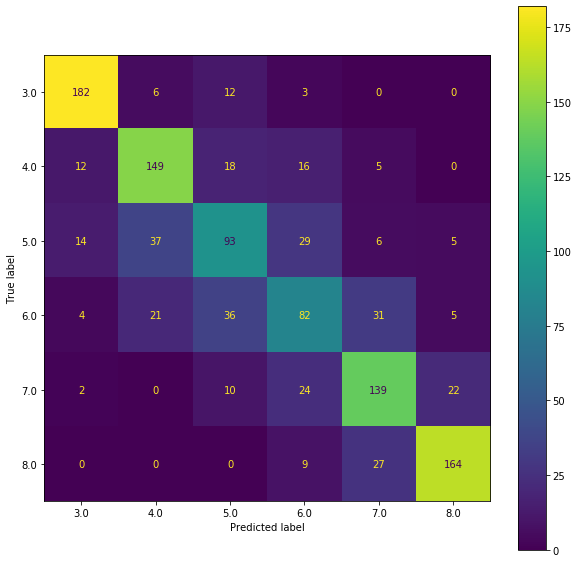

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('tree', DecisionTreeClassifier(max_depth=11))])
Accuracy StratifiedCV: 0.6956147893379192
f1Score StratifiedCV: 0.685933040312667
recall StratifiedCV: 0.6884451369585038
precision StratifiedCV: 0.6847275122415125
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [53]:
Model(X_bal[:,[0,2,9,10]],y_bal, p3, params, test_size, n_splits, random_state, cv)

## 4 Random Forest 
With the Random Forest model, we want to climb a step due to the Decission Tree model that we used before. So, the parameters we have used to define this model are:  'n_estimators':[10,50,100,200],'criterion':['gini','entropy'],'max_depth':[3,None],'max_samples':[int(X_train.shape[0]*r) for r in np.linspace(0.1,1,3)]} 

This model gives us very good results using balanced classes and reducing the dimension.

### 4.1 Setting  parameters for the Unbalanced Random Forest:

In [54]:
estimators4 = [('scale', MinMaxScaler()), ('forestUnb', RandomForestClassifier())]

In [55]:
paramsUnbalanced = {'forestUnb__n_estimators':[10,50,100,200,300],
          'forestUnb__criterion':['gini','entropy'],
          'forestUnb__max_depth':[3,None],
          'forestUnb__max_samples':[int(X.shape[0]*r) for r in np.linspace(0.1,1,3)]}

In [56]:
p4 = Pipeline(estimators4)

### 4.2 Setting Parameters for Balanced Random Forest:

In [57]:
estimators5 = [('scale', MinMaxScaler()), ('forestBal', RandomForestClassifier())]
paramsBalanced = {'forestBal__n_estimators':[10,50,100,200,300],
          'forestBal__criterion':['gini','entropy'],
          'forestBal__max_depth':[3,None],
          'forestBal__max_samples':[int(X_bal.shape[0]*r) for r in np.linspace(0.1,1,3)]}

In [58]:
paramsBalanced = {'forestBal__n_estimators':[10,50,100,200,300],
          'forestBal__criterion':['gini','entropy'],
          'forestBal__max_depth':[3,None],
          'forestBal__max_samples':[int(X_bal.shape[0]*r) for r in np.linspace(0.1,1,3)]}

In [59]:
p5 = Pipeline(estimators5)

### 4.3 Unbalanced Random Forest

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time= 

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 892 but got value 1593

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: E


[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.1s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.1s
[CV] END forestUnb__criterion=gini, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.1s
[CV] END forestUnb__criterion=gin

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 892 but got value 1593

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: E

[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=3, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entr

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 892 but got value 1593

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: E


[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=10; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END forestUnb__criterion=entropy, forestUnb__max_depth=None, forestUnb__max_samples=159, forestUnb__n_estimators=50; total time=   0.0s
[CV] END for

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 892 but got value 1593

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: E

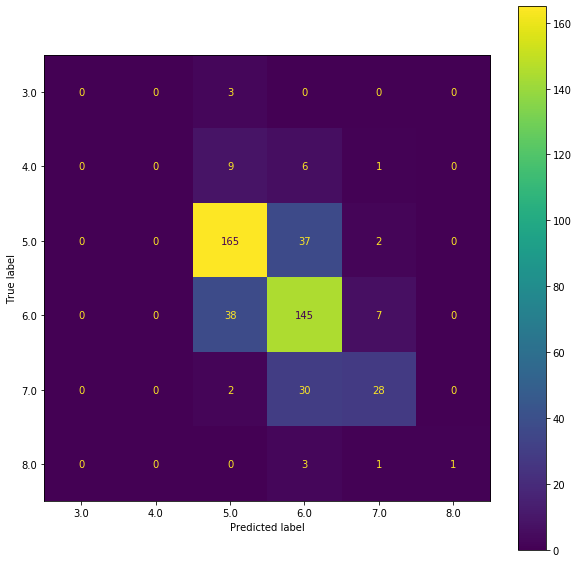

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('forestUnb',
                 RandomForestClassifier(criterion='entropy', max_samples=876,
                                        n_estimators=200))])
Accuracy StratifiedCV: 0.7092050209205021
f1Score StratifiedCV: 0.3980723311739141
recall StratifiedCV: 0.373108015135879
precision StratifiedCV: 0.5224043298047093
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
Model(X,y, p4, paramsUnbalanced, test_size, n_splits, random_state, cv)

### 4.4 Balanced Random Forest

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time= 

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entr

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END fore

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

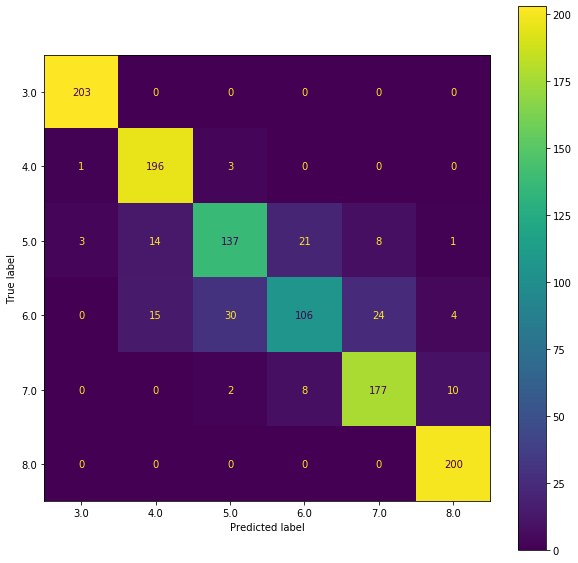

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('forestBal',
                 RandomForestClassifier(max_samples=2130, n_estimators=300))])
Accuracy StratifiedCV: 0.8761822871883062
f1Score StratifiedCV: 0.8655326007642262
recall StratifiedCV: 0.8692035242835718
precision StratifiedCV: 0.8684344604997222
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [61]:
Model(X_bal,y_bal, p5, paramsBalanced, test_size, n_splits, random_state, cv)

### 4.5 Random Forest Using Reduction of Dimensions (Correlation):

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time= 

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=200; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=200; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=300; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=300; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=300; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=300; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=3, forestBal__max_samples=3874, forestBal__n_estimators=300; total time=   0.0s
[CV] END forestBal__criterion=gini, fores

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2169 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=gini

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=3, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.0s
[CV] END forestBal__criterion=entr

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 


[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=10; total time=   0.0s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END forestBal__criterion=entropy, forestBal__max_depth=None, forestBal__max_samples=387, forestBal__n_estimators=50; total time=   0.1s
[CV] END for

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    max_samples=self.max_samples
  File "C:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 2168 but got value 3874

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: 

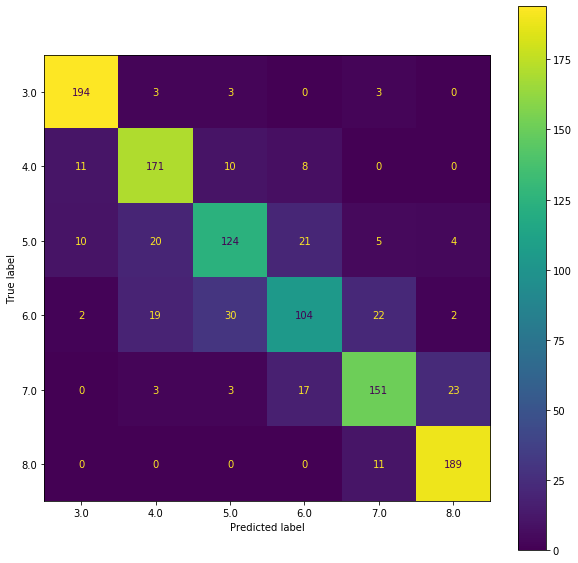

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('forestBal',
                 RandomForestClassifier(max_samples=2130, n_estimators=200))])
Accuracy StratifiedCV: 0.8022355975924333
f1Score StratifiedCV: 0.7932274266087841
recall StratifiedCV: 0.7961801861049859
precision StratifiedCV: 0.7936419652822163
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [62]:
Model(X_bal[:,[0,2,9,10]],y_bal, p5, paramsBalanced, test_size, n_splits, random_state, cv)

## 5 MLPC 

### 5.1 Setting  common parameters for MLPC
In this case, we have choosen a Neuronal Network with 5 layers (100 neurons per each layer). We have only selected an activation function tanh and an alpha of 0.001 because the execution time on my pc is too slow.

Results are good for balanced classes and reducing the dimension.

In [63]:
estimators5 = [('scale', MinMaxScaler()), ('mlpc', MLPClassifier())]

params = {'mlpc__hidden_layer_sizes':[(100,100,100,100,100)],
        'mlpc__activation':[ 'tanh'],
        'mlpc__alpha':[0.001]}

In [64]:
p6 = Pipeline(estimators5)

### 5.1 MLPC Unbalanced

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  11.5s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  12.1s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=   9.2s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=   7.8s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=   7.8s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


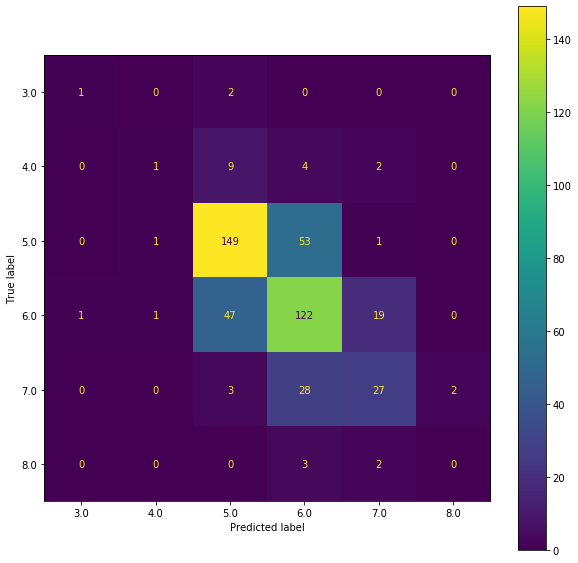

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('mlpc',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(100, 100, 100, 100, 100)))])
Accuracy StratifiedCV: 0.6276150627615062
f1Score StratifiedCV: 0.3869260679443746
recall StratifiedCV: 0.3697217922256622
precision StratifiedCV: 0.442203548085901
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


In [65]:
Model(X,y, p6, params, test_size, n_splits, random_state, cv)

### 5.2 MLPC Balanced

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  19.4s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  19.7s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  18.4s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  18.3s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  18.4s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


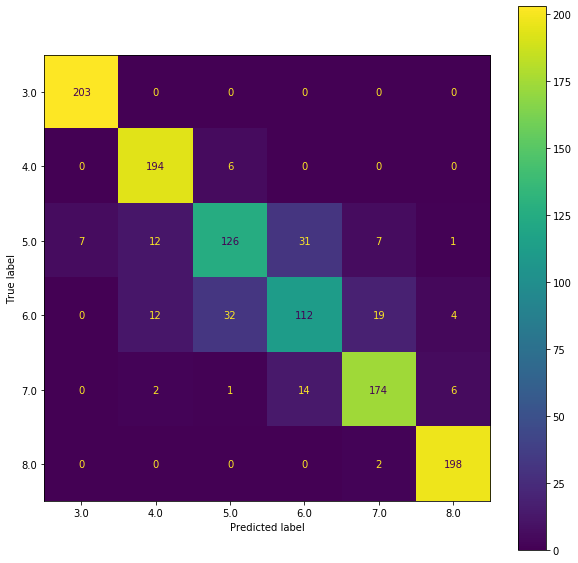

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('mlpc',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(100, 100, 100, 100, 100)))])
Accuracy StratifiedCV: 0.8658641444539983
f1Score StratifiedCV: 0.8559976142058542
recall StratifiedCV: 0.8589549439470776
precision StratifiedCV: 0.8557085946610082
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [66]:
Model(X_bal,y_bal, p6, params, test_size, n_splits, random_state, cv)

### 4.2 MLPC Using Reduction of Dimensions (Correlation)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  19.0s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  17.9s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  18.4s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  19.1s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] END mlpc__activation=tanh, mlpc__alpha=0.001, mlpc__hidden_layer_sizes=(100, 100, 100, 100, 100); total time=  18.1s


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


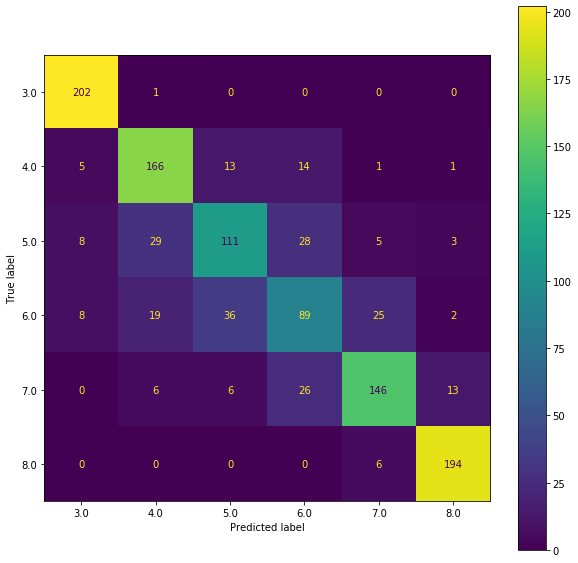

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('mlpc',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               hidden_layer_sizes=(100, 100, 100, 100, 100)))])
Accuracy StratifiedCV: 0.7807394668959587
f1Score StratifiedCV: 0.7681485610602428
recall StratifiedCV: 0.7727763693950805
precision StratifiedCV: 0.7668544712558191
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [67]:
Model(X_bal[:, [0,2,9,10]],y_bal, p6, params, test_size, n_splits, random_state, cv)

## 5 ADABOOST
For the adaboost model we have choosen the next parameters: 

params = {'ada__n_estimators':[1000],
          'ada__learning_rate':[1,0.9,0.8]}
          
The results using this model are really bad, it could be because we have lot of noise in our DataFrame.

### 5.1 Setting  common parameters for MLPC

In [68]:
estimators6 = [('scale', MinMaxScaler()), ('ada', AdaBoostClassifier())]
params = {'ada__n_estimators':[1000],
          'ada__learning_rate':[1,0.9,0.8]}

In [69]:
p7 = Pipeline(estimators6)

### 5.1 ADABOOST Unbalanced

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   2.9s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   2.8s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   2.9s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   2.8s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   3.3s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   2.9s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   2.9s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   3.2s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   2.8s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   3.1s
[CV] END .....ada__learning_rate=0.8, ada__n_estimators=1000; total time=   3.0s
[CV] END .....ada__learning_rate=0.8, ada__n_esti

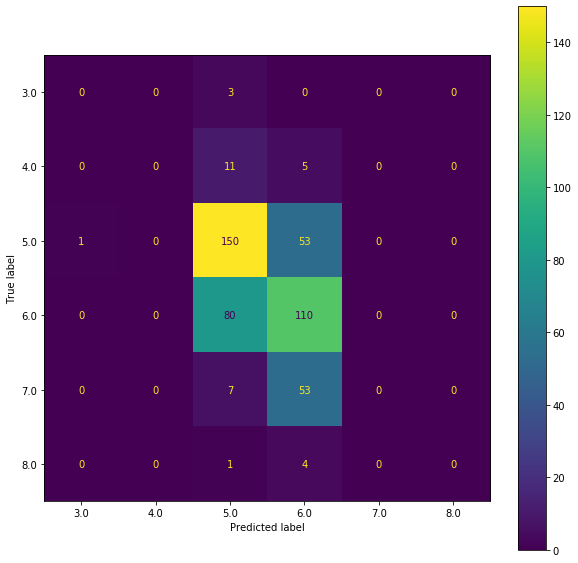

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('ada',
                 AdaBoostClassifier(learning_rate=1, n_estimators=1000))])
Accuracy StratifiedCV: 0.5439330543933054
f1Score StratifiedCV: 0.19800253646163601
recall StratifiedCV: 0.21904024767801858
precision StratifiedCV: 0.18068783068783068
Ocurrencias StratifiedCV: Counter({5.0: 477, 6.0: 443, 7.0: 138, 4.0: 37, 8.0: 13, 3.0: 7})
------------------------


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
Model(X,y, p7, params, test_size, n_splits, random_state, cv)

### 5.2 ADABOOST Balanced

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.5s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.9s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.5s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.4s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.7s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   5.4s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   5.9s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   8.7s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   9.5s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   6.5s
[CV] END .....ada__learning_rate=0.8, ada__n_estimators=1000; total time=   6.6s
[CV] END .....ada__learning_rate=0.8, ada__n_esti

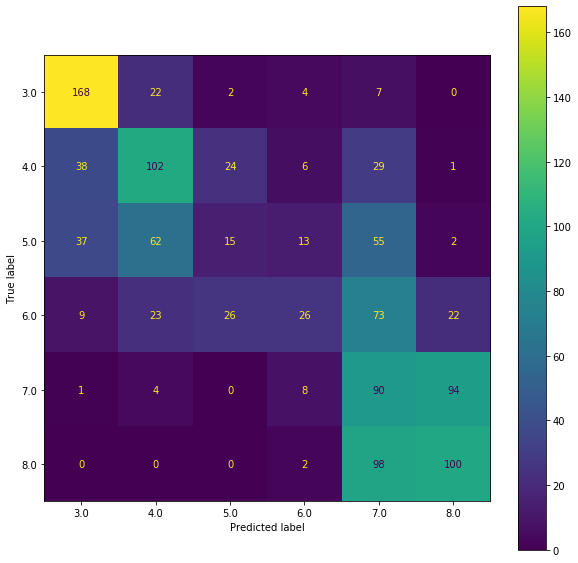

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.8, n_estimators=1000))])
Accuracy StratifiedCV: 0.4307824591573517
f1Score StratifiedCV: 0.39566566087322813
recall StratifiedCV: 0.420202022425534
precision StratifiedCV: 0.4199610409757713
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [71]:
Model(X_bal,y_bal, p7, params, test_size, n_splits, random_state, cv)

### 4.2 MLPC Using Reduction of Dimensions (Correlation)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.7s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   5.0s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   4.0s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   4.3s
[CV] END .......ada__learning_rate=1, ada__n_estimators=1000; total time=   3.7s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   4.2s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   4.0s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   3.9s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   3.8s
[CV] END .....ada__learning_rate=0.9, ada__n_estimators=1000; total time=   4.1s
[CV] END .....ada__learning_rate=0.8, ada__n_estimators=1000; total time=   4.2s
[CV] END .....ada__learning_rate=0.8, ada__n_esti

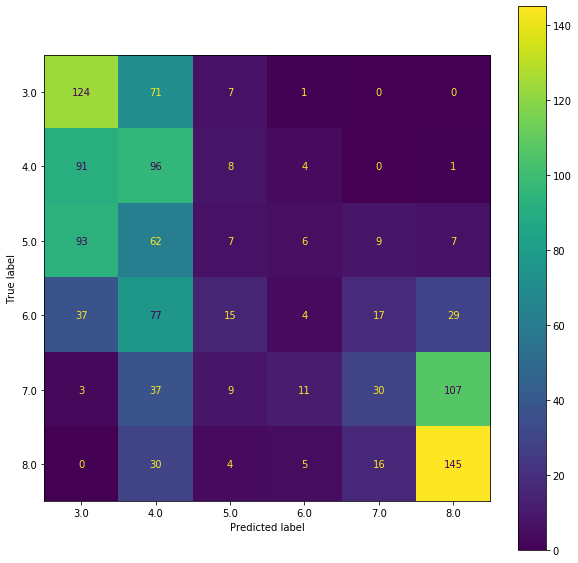

------------------------
Best Classifier: Pipeline(steps=[('scale', MinMaxScaler()),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.9, n_estimators=1000))])
Accuracy StratifiedCV: 0.34909716251074807
f1Score StratifiedCV: 0.28319815632661954
recall StratifiedCV: 0.3380852582264983
precision StratifiedCV: 0.30018725362889453
Ocurrencias StratifiedCV: Counter({3.0: 473, 8.0: 468, 4.0: 466, 7.0: 459, 5.0: 428, 6.0: 417})
------------------------


In [72]:
Model(X_bal[:,[0,2,9,10]],y_bal, p7, params, test_size, n_splits, random_state, cv)